In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from scipy.special import softmax
from scipy.spatial.distance import cdist
from entlearn.utils.general import slog
np.random.seed(42)

# Hyperparameters

## Meaning of the eSPA hyperparameters

### K
This hyperparameter describes the number of discretization boxes to be used, the more K, the more fine-grained the discretization will be.
A good rule of thumb is to set the number of boxes to be at minimum equal to the number of classes in the dataset.
Note that the final number of boxes $K_{end}$ (in the fitted model) will be $K_{end} ≤ K$, since some boxes may become empty during the training process and will be removed.

### $\varepsilon_W$
The value of $\varepsilon_W$ represents the "strength" of the entropic regularization in the loss function. Interestingly, its effect is exerted in the analytical solution of the $W$ step, which looks like this:
$$W^* = \text{softmax}(-\frac{1}{T \varepsilon_W} b)$$
where $b$ are the errors in each dimension, summed over $T$.
Thus, $\varepsilon_W$ acts as the temperature of the softmax function. Let us have a closer look in the following example

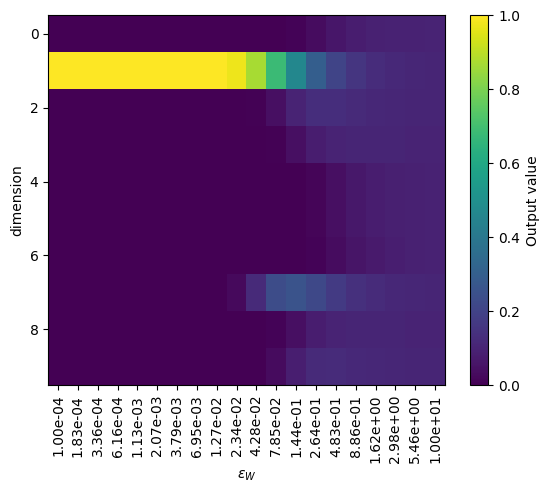

In [2]:
x = np.random.rand(10)
Ts = np.logspace(-4, 1, 20)

x_softmax = np.zeros((x.shape[0], len(Ts)))
for idx,t in enumerate(Ts):
    x_softmax[:,idx] = softmax(x/t)

plt.imshow(x_softmax, aspect='auto', interpolation='none')
plt.colorbar(label='Output value')
plt.xlabel(r"$\varepsilon_W$")
plt.xticks(np.arange(len(Ts)), ["%.2e" %t for t in Ts], rotation=90)
plt.ylabel("dimension")
plt.show()

Note how increasing the value of $\varepsilon_W$ it is possible to obtain progressively more maximum entropy vectors, and viceversa by decreasing its value we obtain minimum entropy vectors.

The same applies to $W$, by changing epsilon we can control the entropy of $W$, and thus the strenght of the dimensionality reduction.

## $\varepsilon_{CL}$
This parameter influences the strength of the classification term in the optimization problem. 
Note that it affects the solution of $\Gamma$ step. In fact, if $\varepsilon_{C} \rightarrow 0$, we will have the same solution as k-means, whereas if $\varepsilon_C \rightarrow \infty$ the actual distance between the points and the centroids will play less role in the affiliation process than their labels.

As an example, let us consider some synthetic data, and see how the classification problem affects the final clustering.

In [3]:
from sklearn.datasets import make_blobs
centroids = np.array([[.8,.8], [.2,.2], [.2,.8]])
X_example, y_example = make_blobs(n_samples=100, n_features=2,centers=centroids, cluster_std=[.1,.1,.2])

pi = np.zeros((100,2))
pi[y_example!=1,0] = 1
pi[y_example==1,1] = 1 

L = np.array([[1,0,0.5],[0,1,0.5]])

Let us first plot the data, and overimpose the centroids, each of which colored according to $\Lambda$.

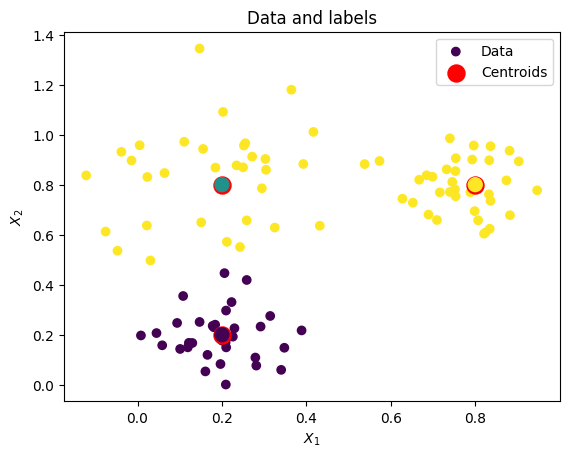

In [4]:
plt.scatter(X_example[:,0], X_example[:,1], c=pi[:,0], label="Data")
plt.scatter(centroids[:,0], centroids[:,1], s=150, c='r', label="Centroids")
plt.scatter(centroids[:,0], centroids[:,1], s=100, c=L[0,:])
plt.title('Data and labels')
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.legend()
plt.show()

If we wanted to assign the points to the centroids using kmeans, we would use the pairwise squared euclidean distance between the points and the centroids, which is shown below.

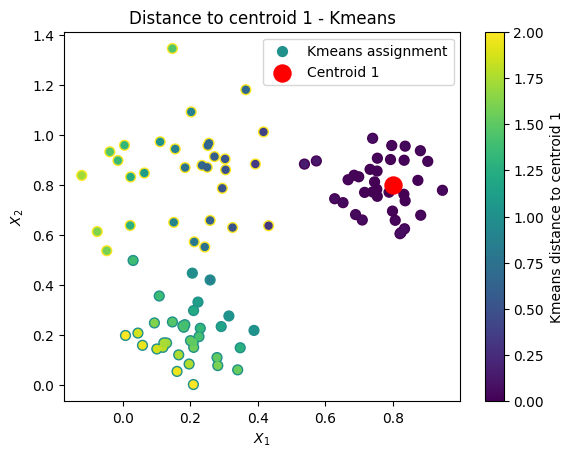

In [5]:
G_kmeans = cdist(X_example,centroids, "sqeuclidean") # distances between points and centroids

plt.scatter(X_example[:,0], X_example[:,1], s=50, c=np.argmin(G_kmeans,1), cmap='viridis', label="Kmeans assignment")
plt.colorbar(label='Kmeans distance to centroid 1')
plt.scatter(X_example[:,0], X_example[:,1], s=25, c=G_kmeans[:,0])
plt.scatter(centroids[0,0], centroids[0,1], s=150, c='r', label="Centroid 1")
plt.title('Distance to centroid 1 - Kmeans')
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.legend()
plt.show()

The inclusion of the influence of the labels in the affiliation can be controlled using $\varepsilon_C$.
Selecting a small value of $\varepsilon_C$ (e.g., $1e-10$) we can see that the distance between the points and the centroids is almost unchanged, and the clustering is similar to kmeans.

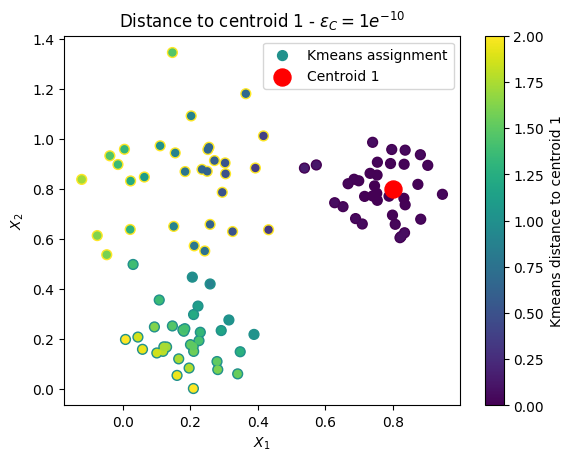

In [6]:
epsC1 = 1e-10, 
G_kmeans_and_labels_1 = G_kmeans - epsC1 * (np.matmul(pi, slog(L)))

plt.scatter(X_example[:,0], X_example[:,1], s=50, c=np.argmin(G_kmeans_and_labels_1, axis=1), cmap='viridis', label="Kmeans assignment")
plt.colorbar(label='Kmeans distance to centroid 1')
plt.scatter(X_example[:,0], X_example[:,1], s=25, c=G_kmeans_and_labels_1[:,0])
plt.scatter(centroids[0,0], centroids[0,1], s=150, c='r', label="Centroid 1")

plt.title(r'Distance to centroid 1 - $\varepsilon_C=1e^{-10}$')
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.legend()
plt.show()

Selecting a larger value of $\varepsilon_C$ (e.g., $1$) we can observe how the "distance" between the upper-left points and the centroid *with matching conditional probability* is reduced, and the clustering is more strongly influenced by the labels.

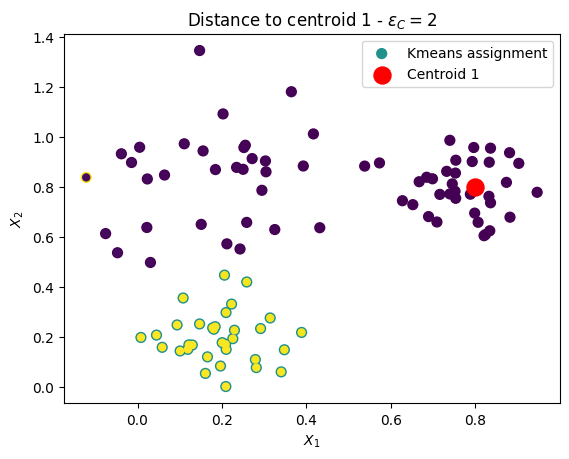

In [7]:
epsC1 = 1, 
G_kmeans_and_labels_2 = G_kmeans - epsC1 * (np.matmul(pi, slog(L)))

plt.scatter(X_example[:,0], X_example[:,1], s=50, c=np.argmin(G_kmeans_and_labels_2, 1), cmap='viridis', label="Kmeans assignment")
plt.scatter(X_example[:,0], X_example[:,1], s=25, c=G_kmeans_and_labels_2[:,0])
plt.scatter(centroids[0,0], centroids[0,1], s=150, c='r', label="Centroid 1")
plt.title(r'Distance to centroid 1 - $\varepsilon_C=2$')
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.legend()
plt.show()

## Hyperparameter search

Within `entlearn`, a special model is provided called `eSPASearch`, which implements automatic hyperparameter optimization

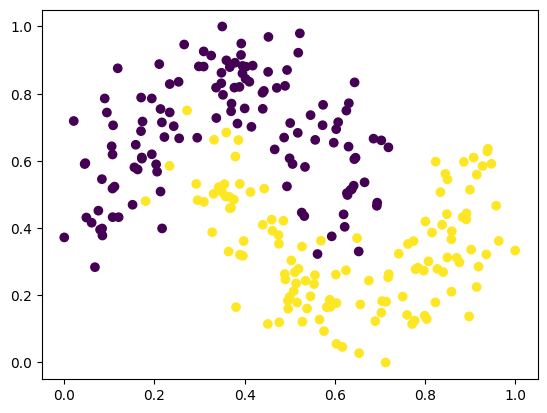

In [8]:
T = 250
D = 10

X, y = make_moons(n_samples=T, noise=0.2, random_state=42)
X = np.column_stack((X, np.random.rand(T, D - 2)))
X = MinMaxScaler().fit_transform(X,y)
plt.scatter(X[:,0], X[:,1], c=y)

First, we can define a space in which to search from.

In [9]:
from entlearn.models.eSPA_search import Hyperparameters_eSPA, eSPASearch

space = Hyperparameters_eSPA(
    K = (6,12),
    epsW = (1e-3, 1e-1),
    epsC = (1e-3, 1e-1)
)

Note that, in case not all parameters are provided by the user, some default range will be used. You can inspect the range by:

In [10]:
space

Hyperparameter ranges:
	K: 	from 6 to 12
	epsW: 	from 1.00e-03 to 1.00e-01
	epsC: 	from 1.00e-03 to 1.00e-01

Then, this space can be provided to `eSPASearch`, together with additional parameters, such as:

- `n_search_iters`: the number of combinations of hyperparameters to sample from
- `anneals`: the number of annealing to use for each combination
- `n_jobs`: the number of jobs to use

In [11]:
search = eSPASearch(
    n_search_iters=500,
    space = space,
    anneals = 10,
    n_jobs=-1
)

In [12]:
search.fit(X,y)

[I 2025-07-04 09:11:23,748] A new study created in memory with name: 
[I 2025-07-04 09:11:24,336] Trial 1 finished with values: [0.9783999999999999, 20.0] and parameters: {'K': 6, 'epsW': 0.042064415420653964, 'epsC': 0.007839817474038275, 'kpp_init': False}.
[I 2025-07-04 09:11:24,339] Trial 3 finished with values: [0.9623999999999999, 20.0] and parameters: {'K': 6, 'epsW': 0.047462260462095174, 'epsC': 0.047148485974778685, 'kpp_init': False}.
[I 2025-07-04 09:11:24,388] Trial 0 finished with values: [0.9136, 17.0] and parameters: {'K': 8, 'epsW': 0.0011320836903347777, 'epsC': 0.0026609710666490307, 'kpp_init': False}.
[I 2025-07-04 09:11:24,439] Trial 4 finished with values: [0.9672, 26.0] and parameters: {'K': 8, 'epsW': 0.0428545230941516, 'epsC': 0.018281004937842047, 'kpp_init': True}.
[I 2025-07-04 09:11:24,447] Trial 6 finished with values: [0.9136, 17.0] and parameters: {'K': 8, 'epsW': 0.007903541297225217, 'epsC': 0.04575809463912093, 'kpp_init': True}.
[I 2025-07-04 09:11

Number of trials on the Pareto front: 11
Trial with highest accuracy: 
	number: 347
	params: {'K': 8, 'epsW': 0.042064415420653964, 'epsC': 0.083530074171467, 'kpp_init': False}
	values: [1.0, 23.0]


eSPASearch(anneals=10, n_search_iters=500,
           space=Hyperparameter ranges:
	K: 	from 6 to 12
	epsW: 	from 1.00e-03 to 1.00e-01
	epsC: 	from 1.00e-03 to 1.00e-01)

In [13]:
print(search.best_trial.values)

[1.0, 23.0]


Information about all tried hyperparameter combinations is returned in `search.info_all_trials`, and for the trials on the pareto front there is a separate output `search.info_pareto_trials"

In [14]:
search.info_all_trials

,val_score,n_params,epsW,epsC,K,kpp_init,fit_time
0,0.9136,17.0,0.001132,0.002661,8.0,0.0,0.052919
1,0.9784,20.0,0.042064,0.007840,6.0,0.0,0.032352
2,0.9776,26.0,0.012136,0.062691,9.0,1.0,0.087426
3,0.9624,20.0,0.047462,0.047148,6.0,0.0,0.039592
4,0.9672,26.0,0.042855,0.018281,8.0,1.0,0.073122
...,...,...,...,...,...,...,...
495,0.9776,26.0,0.012136,0.062691,9.0,0.0,0.022518
496,0.9160,15.0,0.004063,0.009682,7.0,1.0,0.029040
497,0.9096,13.0,0.003124,0.004715,6.0,0.0,0.041073
498,0.9632,26.0,0.046981,0.028805,9.0,0.0,0.001385


In [15]:
search.info_pareto_trials

,val_score,n_params,epsW,epsC,K,kpp_init
2,0.9400,11.0,0.018553,0.001677,6.0,0.0
3,0.9456,13.0,0.015801,0.047996,6.0,0.0
4,0.9456,13.0,0.015801,0.052421,6.0,0.0
8,0.9456,13.0,0.015801,0.052421,6.0,0.0
9,0.9616,15.0,0.010229,0.021655,7.0,1.0
1,0.9912,17.0,0.033157,0.021796,6.0,0.0
7,0.9912,17.0,0.029393,0.047996,6.0,0.0
0,0.9928,20.0,0.033157,0.053675,6.0,0.0
5,0.9928,20.0,0.033157,0.087914,6.0,0.0
10,0.9928,20.0,0.033157,0.027629,6.0,0.0


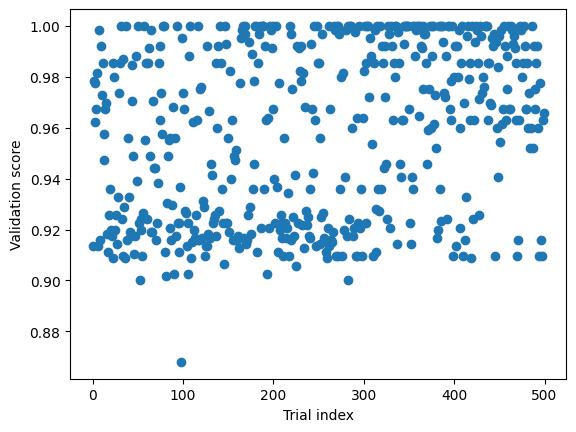

In [16]:
plt.scatter(search.info_all_trials.index, search.info_all_trials['val_score'])
plt.xlabel("Trial index")
plt.ylabel("Validation score")
plt.show()

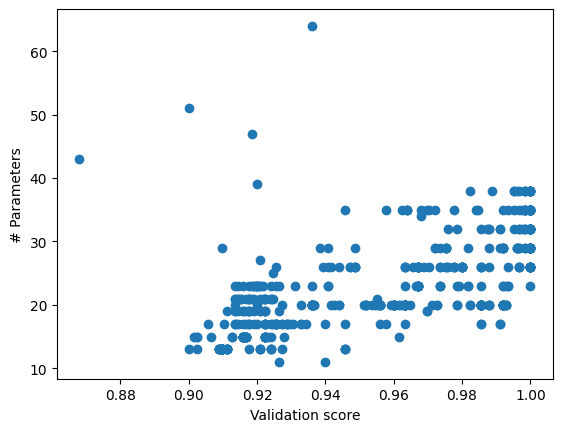

In [17]:
plt.scatter( search.info_all_trials['val_score'], search.info_all_trials['n_params'])
plt.xlabel("Validation score")
plt.ylabel("# Parameters")
plt.show()

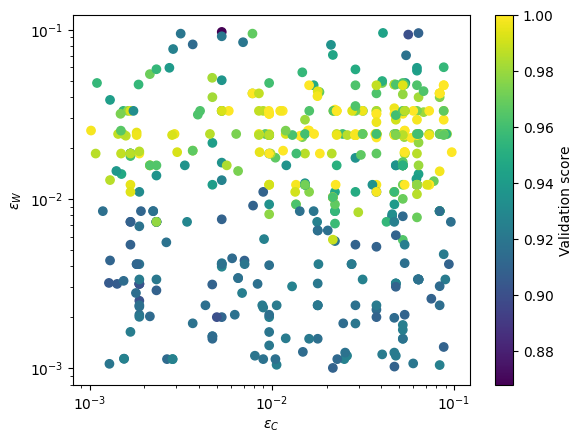

In [18]:
plt.scatter( search.info_all_trials['epsC'], search.info_all_trials['epsW'], c=search.info_all_trials['val_score'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$\varepsilon_{C}$")
plt.ylabel(r"$\varepsilon_{W}$")
plt.colorbar(label="Validation score")
plt.show()

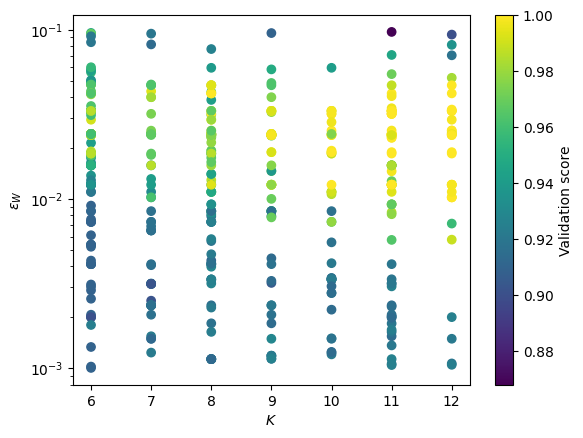

In [19]:
plt.scatter( search.info_all_trials['K'], search.info_all_trials['epsW'], c=search.info_all_trials['val_score'])
plt.yscale('log')
plt.xlabel(r"$K$")
plt.ylabel(r"$\varepsilon_{W}$")
plt.colorbar(label="Validation score")
plt.show()

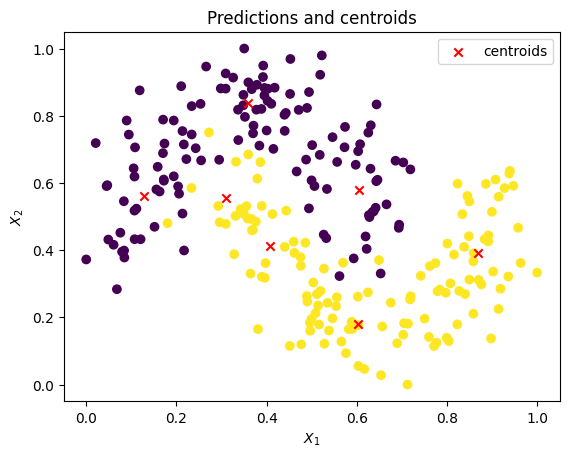

In [20]:
preds = search.predict_proba(X)

plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(search.best_model.fitted_model_.C_[0,:], search.best_model.fitted_model_.C_[1,:], marker='x', c='r', label="centroids")
plt.title(r'Predictions and centroids')
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.legend()
plt.show()